In [41]:
import sys
import os
import time
import argparse
# sys.path.append('/home/Data/FoodDetection/Serving/ocr/pipeline/CRAFT_pytorch')
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image
import cv2
from skimage import io
import numpy as np
import craft_utils
# import test
from test_ import copyStateDict
# from test import test_net
import imgproc
import file_utils
import json
import zipfile
import pandas as pd
import traceback

from craft import CRAFT
from collections import OrderedDict
from crop_words_ import crop, generate_words
from soynlp.hangle import levenshtein, jamo_levenshtein ##20201026 newly added (install through pip if needed)
from craft import CRAFT

from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import sys
import os
import time, errno
import cv2
from skimage import io
import numpy as np
import pandas as pd
import imgproc as imgproc
import test_
from crop_words_ import crop, generate_words
import torch
import traceback
import crop_words_
import re

In [2]:
def get_image_center(pts):
    height_center = (pts[:,0].max() + pts[:,0].min())/2
    width_center = (pts[:,1].max() + pts[:,1].min())/2
    return (int(height_center), int(width_center))

In [3]:
def get_pts_center(pts):
    height_center = (pts[:,0].max() + pts[:,0].min())/2
    width_center = (pts[:,1].max() + pts[:,1].min())/2
    return (int(width_center), int(height_center))

In [4]:
def euclidean_distance(x, y):   
#     return np.sqrt(np.sum((x - y) ** 2))
    x = np.asarray(x)
    y = np.asarray(y)
    return np.linalg.norm(x - y)

In [5]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args['canvas_size'], interpolation=cv2.INTER_LINEAR, 
                                                                          mag_ratio=args['mag_ratio'])
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

#     if args.show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

In [13]:
#craft_mlt_25k.pth
args = {"trained_model":'/home/Data/FoodDetection/Serving/ocr/pipeline/craft_mlt_25k.pth',
        "text_threshold":0.7,
        "low_text":0.4,
        "link_threshold":0.4,
        "cuda":False,
        "canvas_size":1280,
        "mag_ratio": 1.5,
        "poly":False,
        "show_time":False,
        "test_folder": "/home/Data//FoodDetection/AI_OCR/CRAFT/",
        "filepath": '/home/Data//FoodDetection/data/text_detection/RDProject/ocr_1000055.jpg',
        "refine" : False,
         "refiner_model": 'weights/craft_refiner_CTW1500.pth',

        "IMG_WIDTH": 136,
        "IMG_HEIGHT": 136,
        "IMG_CHANNELS": 3,
        "classfication Model": "mobilenet_model"
}

#args = parser.parse_args()

""" For test images in a folder """

filepath = args['filepath']

In [12]:
image_list = [filepath]
image_names = []
image_paths = []

# CUSTOMISE START
start = args["test_folder"] + '01_src'  # '/Data/CRAFT_process/test_1/01_images'

for num in range(len(image_list)):
    image_names.append(args['filepath'])

crop_path = args["test_folder"] + '03_crop'
data = pd.DataFrame(columns=['image_name', 'word_bboxes', 'pred_words', 'align_text'])
data['image_name'] = image_names

# load net
net = CRAFT()  # initialize
print('Loading weights from checkpoint (' + args["trained_model"] + ')')
if args["cuda"]:
    net.load_state_dict(copyStateDict(torch.load(args["trained_model"])))
else:
    net.load_state_dict(copyStateDict(torch.load(args["trained_model"], map_location='cpu')))

if args["cuda"]:
    net = net.cuda()
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = False

_ = net.eval()

Loading weights from checkpoint (/home/Data/FoodDetection/Serving/ocr/pipeline/craft_mlt_25k.pth)


In [7]:

# LinkRefiner
refine_net = None
if args["refine"]:
    from refinenet import RefineNet

    refine_net = RefineNet()
    if args["cuda"]:
        refine_net.load_state_dict(copyStateDict(torch.load(args["refiner_model"])))
        refine_net = refine_net.cuda()
        refine_net = torch.nn.DataParallel(refine_net)
    else:
        refine_net.load_state_dict(copyStateDict(torch.load(args["refiner_model"], map_location='cpu')))

    refine_net.eval()
    args['poly'] = True

# load data
for k, image_path in enumerate(image_list):
    print("Test image {:d}/{:d}: {:s}".format(k + 1, len(image_list), image_path), end='\r')
    image = imgproc.loadImage(image_path)

    bboxes, polys, det_scores = test_net(net, image, args["text_threshold"],
                                                              args["link_threshold"],
                                                              args["low_text"], args["cuda"], args["poly"],
                                                              refine_net)
    bbox_score = {}

    for box_num in range(len(bboxes)):
        key = str(det_scores[box_num])
        item = bboxes[box_num]
        bbox_score[key] = item

    data['word_bboxes'][k] = bbox_score
    # save score text
    ##filename, file_ext = os.path.splitext(os.path.basename(image_path))
    ##mask_file = result_folder + "/res_" + filename + '_mask.jpg'        # '/Data/CRAFT_process/test_1/02_map/res_' + filename + '_mask.jpg'

    ##print(mask_file)
    ##cv2.imwrite(mask_file, score_text)

    ##file_utils.saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder+'/')
# data.to_csv(args["test_folder"] + 'data.csv', sep=',', na_rep='Unknown')
# del data
# data = pd.read_csv(args["test_folder"] + 'data.csv')
# Crop

for image_num in range(data.shape[0]):
    image = cv2.imread(os.path.join(start, data['image_name'][image_num]))
    image_name = data['image_name'][image_num].strip('.jpg')
    score_bbox = data['word_bboxes'][image_num].split('),')
    cropped_imgs, pts_list, image = generate_words(image_name, score_bbox, image, crop_path)
#                     print('cropped imgs : ',cropped  
    # print(cropped_imgs.shape)

#                 recognition_list = run(cropped_imgs)
#                 if len(recognition_list) == 0 :
#                     print("imagelen: " , len(recognition_list))
#                 print("imagename: " , recognition_list)
#             print('cropped_imgs : ', cropped_imgs)

ValueError: too many values to unpack (expected 2)

In [ ]:
bbox_score = {}

for box_num in range(len(bboxes)):
    key = str(det_scores[box_num])
    item = bboxes[box_num]
    bbox_score[key] = item

data['word_bboxes'][k] = bbox_score

for image_num in range(data.shape[0]):
    image = cv2.imread(os.path.join(start, data['image_name'][image_num]))
    image_name = data['image_name'][image_num].strip('.jpg')
    score_bbox = data['word_bboxes'][image_num].split('),')
    cropped_imgs, pts_list, image = generate_words(image_name, score_bbox, image, crop_path)

In [ ]:
for image_num in range(data.shape[0]):
    image = cv2.imread(os.path.join(start, data['image_name'][image_num]))
    image_name = data['image_name'][image_num].strip('.jpg')
    score_bbox = data['word_bboxes'][image_num].split('),')
    cropped_imgs, pts_list, image = generate_words(image_name, score_bbox, image, crop_path)

In [ ]:
cropped_list = []
pts_list = []
num_bboxes = len(score_bbox)
for num in range(num_bboxes):
    bbox_coords = score_bbox[num].split(':')[-1].split(',\n')
    if bbox_coords!=['{}']:
      l_t = float(bbox_coords[0].strip(' array([').strip(']').split(',')[0])
      t_l = float(bbox_coords[0].strip(' array([').strip(']').split(',')[1])
      r_t = float(bbox_coords[1].strip(' [').strip(']').split(',')[0])
      t_r = float(bbox_coords[1].strip(' [').strip(']').split(',')[1])
      r_b = float(bbox_coords[2].strip(' [').strip(']').split(',')[0])
      b_r = float(bbox_coords[2].strip(' [').strip(']').split(',')[1])
      l_b = float(bbox_coords[3].strip(' [').strip(']').split(',')[0])
      b_l = float(bbox_coords[3].strip(' [').strip(']').split(',')[1].strip(']'))
      pts = np.array([[int(l_t), int(t_l)], [int(r_t) ,int(t_r)], [int(r_b) , int(b_r)], [int(l_b), int(b_l)]])


-----

In [145]:
wss_total = []
for n_cluster in range(1, len(pts_list)+1):
    kmeans = KMeans(n_clusters=n_cluster)
    pred = kmeans.fit_predict(np.asarray(center_list))
    w_center = kmeans.cluster_centers_
    ss = 0
    for pred_idx, point in zip(pred, center_list):
        e_dist = euclidean_distance(w_center[pred_idx], point)
        ss += e_dist**2
    wss = np.sqrt(ss)
    wss_total.append(wss)

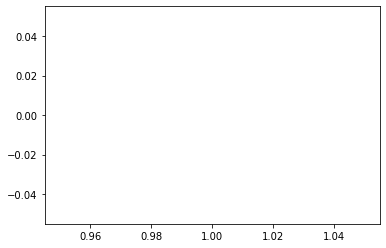

In [146]:
x = list(range(1, len(wss_total)+1))
plt.plot(x,  wss_total)

In [130]:
wss_total

[169.15476148584565, 18.601075237738275, 0.0]

In [38]:
kmeans = KMeans(n_clusters=2)
pred = kmeans.fit_predict(np.asarray(center_list))

In [39]:
pred

array([0, 0, 1, 0, 0, 1, 1], dtype=int32)

In [77]:
df = pd.DataFrame(pred, columns=['cls'])
df_idx = df[df['cls']==0].index

In [111]:
cluster_dict = {}
for idx in df_idx:
    cluster_dict[idx] = cropped_imgs[idx]

In [112]:
for k, v in cluster_dict.items():
    _img = Image.fromarray(v)
    _img = _img.resize((50,50))
    cluster_dict[k] = np.asarray(_img)

In [116]:
for size in reversed(range(len(cluster_dict))):
    max_i = 0
    for i in range(1, 1+size):
        if x[i] > x[max_i]:
            max_i = i
    x[max_i], x[size] = x[size], x[max_i]

2
1
0


In [10]:
def get_within_center(point_list):
    point_arr = np.asarray(point_list)
    within_center_h = point_arr[:,0].sum()/2
    within_center_w = point_arr[:,1].sum()/2
    return (int(within_center_h), int(within_center_w))

In [11]:
w_center = get_within_center([center1, center2])
w_center

(219, 112)

In [59]:
main_cluster = cropped_imgs[[0,1,3,4]]

In [ ]:
for cropped_img in cropped_imgs:
    _img = Image.fromarray(cropped_img)
    _img = _img.resize((50,50))
    
img_.resize((50,50))

--------

In [9]:
import importlib
importlib.reload(crop_words_)

<module 'crop_words_' from '/home/Data/FoodDetection/AI_OCR/CRAFT/crop_words_.py'>

In [14]:
def Detection(net, urlFilepath):
    try:
        #t = time.time()

        # CRAFT
        cuda_stats = False
        device = torch.device('cpu')
#         device = torch.device('cuda')
        if device.type == 'cpu':
            cuda_stats = False
        else:
            cuda_stats = True

        #"cuda":False, True를 False로 수정 
        args = {"trained_model":'/data/OCR_code/Pipeline/craft_mlt_25k.pth',
                "text_threshold":0.7,
                "low_text":0.4,
                "link_threshold":0.4,
                "cuda":cuda_stats, 
                "canvas_size":1280,
                "mag_ratio": 1.5,
                "poly":False,
                "show_time":False,
                "test_folder": "/data/OCR_dir/",
                "filepath": '/home/Data//FoodDetection/data/text_detection/RDProject/ocr_1000056.jpg',
                "refine" : False,
                 "refiner_model": 'weights/craft_refiner_CTW1500.pth'
        }

        #date = time.strftime('%Y%m%d%H%M%S', time.localtime(time.time()))

        filename = urlFilepath.split("/")[-1]
        
        # 저장 된 이미지 확인
        #filepath = "/Data/CRAFT_process/test_1/01_images/"+str(date)+filename.rstrip()
        
        filepath = urlFilepath

        if os.path.isfile(filepath):
            #print( "Yes. it is a file")

            ##if sys.argv[1] is null:
            # filepath = args["filepath"]

            # image_list = [args.filepath]
            image_list = [filepath]
            image_names = []
            image_paths = []

            # CUSTOMISE START
            ##start = '/Data/CRAFT_process/test_1/01_images'  
            start = filepath.split(filename)[0]    # 파일 경로에 따라 Flexible하게 결정

            for num in range(len(image_list)):
                image_names.append(os.path.relpath(image_list[num], start))

            ###result_folder = args.test_folder+'02_map'
            ###if not os.path.isdir(result_folder):
            ###    os.mkdir(result_folder)

            crop_path = start+'%s_crop'%(filename.split('.')[0])
            
            if not os.path.isdir(crop_path):
                os.mkdir(crop_path)

            data = pd.DataFrame(columns=['image_name', 'word_bboxes', 'pred_words', 'align_text'])
            data['image_name'] = image_names
            
            box_idx = 0
            bbox_dict = {}

            # load data
            for k, image_path in enumerate(image_list):
#                 print("Test image {:d}/{:d}: {:s}".format(k + 1, len(image_list), image_path), end='\r')
                image = imgproc.loadImage(image_path)

                bboxes, polys, score_text, det_scores = test_.test_net(net, image, args["text_threshold"],
                                                                          args["link_threshold"],
                                                                          args["low_text"], args["cuda"], args["poly"],
                                                                          args)  # refinenet = None

                bbox_score = {}
                bbox_list = []

                for box_num in range(len(bboxes)):
                    if det_scores[box_num] < 0.85: # score filtering
                        continue
                    key = str(det_scores[box_num])
                    item = bboxes[box_num]
                    bbox_dict[box_idx] = item.tolist()
                    box_idx += 1
                    bbox_score[key] = item
                
                data['word_bboxes'][k] = bbox_score
                

            csv_file = start+'%s_data.csv'%(filename.split('.')[0]) ### 처리한 이미지 이름_data.csv

            data.to_csv(csv_file, sep=',', na_rep='Unknown')
            del data

            data = pd.read_csv(csv_file)
            # Crop

            for image_num in range(data.shape[0]):
                image = cv2.imread(os.path.join(start, data['image_name'][image_num]))
                image_name = data['image_name'][image_num].strip('.jpg')
                score_bbox = data['word_bboxes'][image_num].split('),')
                cropped_imgs = crop_words_.generate_words(image_name, score_bbox, image, crop_path)
            
            print("=========Text Detection and Crop Ends ============")
              
#         else:
#             raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filepath)


    except Exception as e:  # 모든 예외의 에러 메시지를 출력할 때는 Exception을 사용
#         print('예외가 발생했습니다.', e)
        traceback.print_exc()
        return str(e), 400
    return [bbox_dict, cropped_imgs], 200
#     return data

In [82]:
def get_weight_df(pts_list, img_center, recognition_list):
    euclidean_list = []
    center_point_list = []
    area_list = []
    for pts_ in pts_list:
        center_point = get_pts_center(pts_)
        image[center_point[0]-3 : center_point[0]+3, center_point[1]-3: center_point[1]+3] = (0,255,0)
        center_point_list.append(center_point)
        euclidean = euclidean_distance(img_center, center_point)
        euclidean_list.append(euclidean)
        area = cv2.contourArea(pts_)
        area_list.append(area)
    image_area = image.shape[0] * image.shape[1]
    crop_df = pd.DataFrame({'center_point' : center_point_list, 'euclidean_list' : euclidean_list, 'area_list' : area_list, 
                            'recognition_list' : recognition_list})
    
    return crop_df, image_area

In [49]:
def fine_filtering(crop_df, cropped_array, n_crop=4):
    crop_df = crop_df.sort_values(by=['area_list'], ascending=False).head(n_crop)
    filtered_idx = crop_df.index
    cropped_array = cropped_array[filtered_idx]
    
    return crop_df, cropped_array

In [43]:
def get_weight_ratio(crop_df, img_center):
    max_dist = euclidean_distance(img_center,(0,0))
    ed_ratio = 1 - (crop_df['euclidean_list'] / max_dist)
    
    area_ratio = [x/image_area for x in crop_df['area_list']]
    if len(area_ratio)==1:
        area_ratio=1.0
    else:
        area_ratio = (np.asarray(area_ratio) - min(area_ratio))/(max(area_ratio) - min(area_ratio)) + 0.2 
    area_ratio = np.log10(area_ratio * 10)
    
    total_ratio = ed_ratio * area_ratio
    return total_ratio.values

In [64]:
[bbox_dict, (cropped_array, pts_list, image)], res_code = Detection(net, '/home/Data//FoodDetection/data/text_detection/RDProject/ikea.jpg')

<class 'torch.Tensor'>
torch.Size([1, 3, 1280, 1280])

infer/postproc time : 7.679/0.020
=========Text Detection and Crop Ends ============


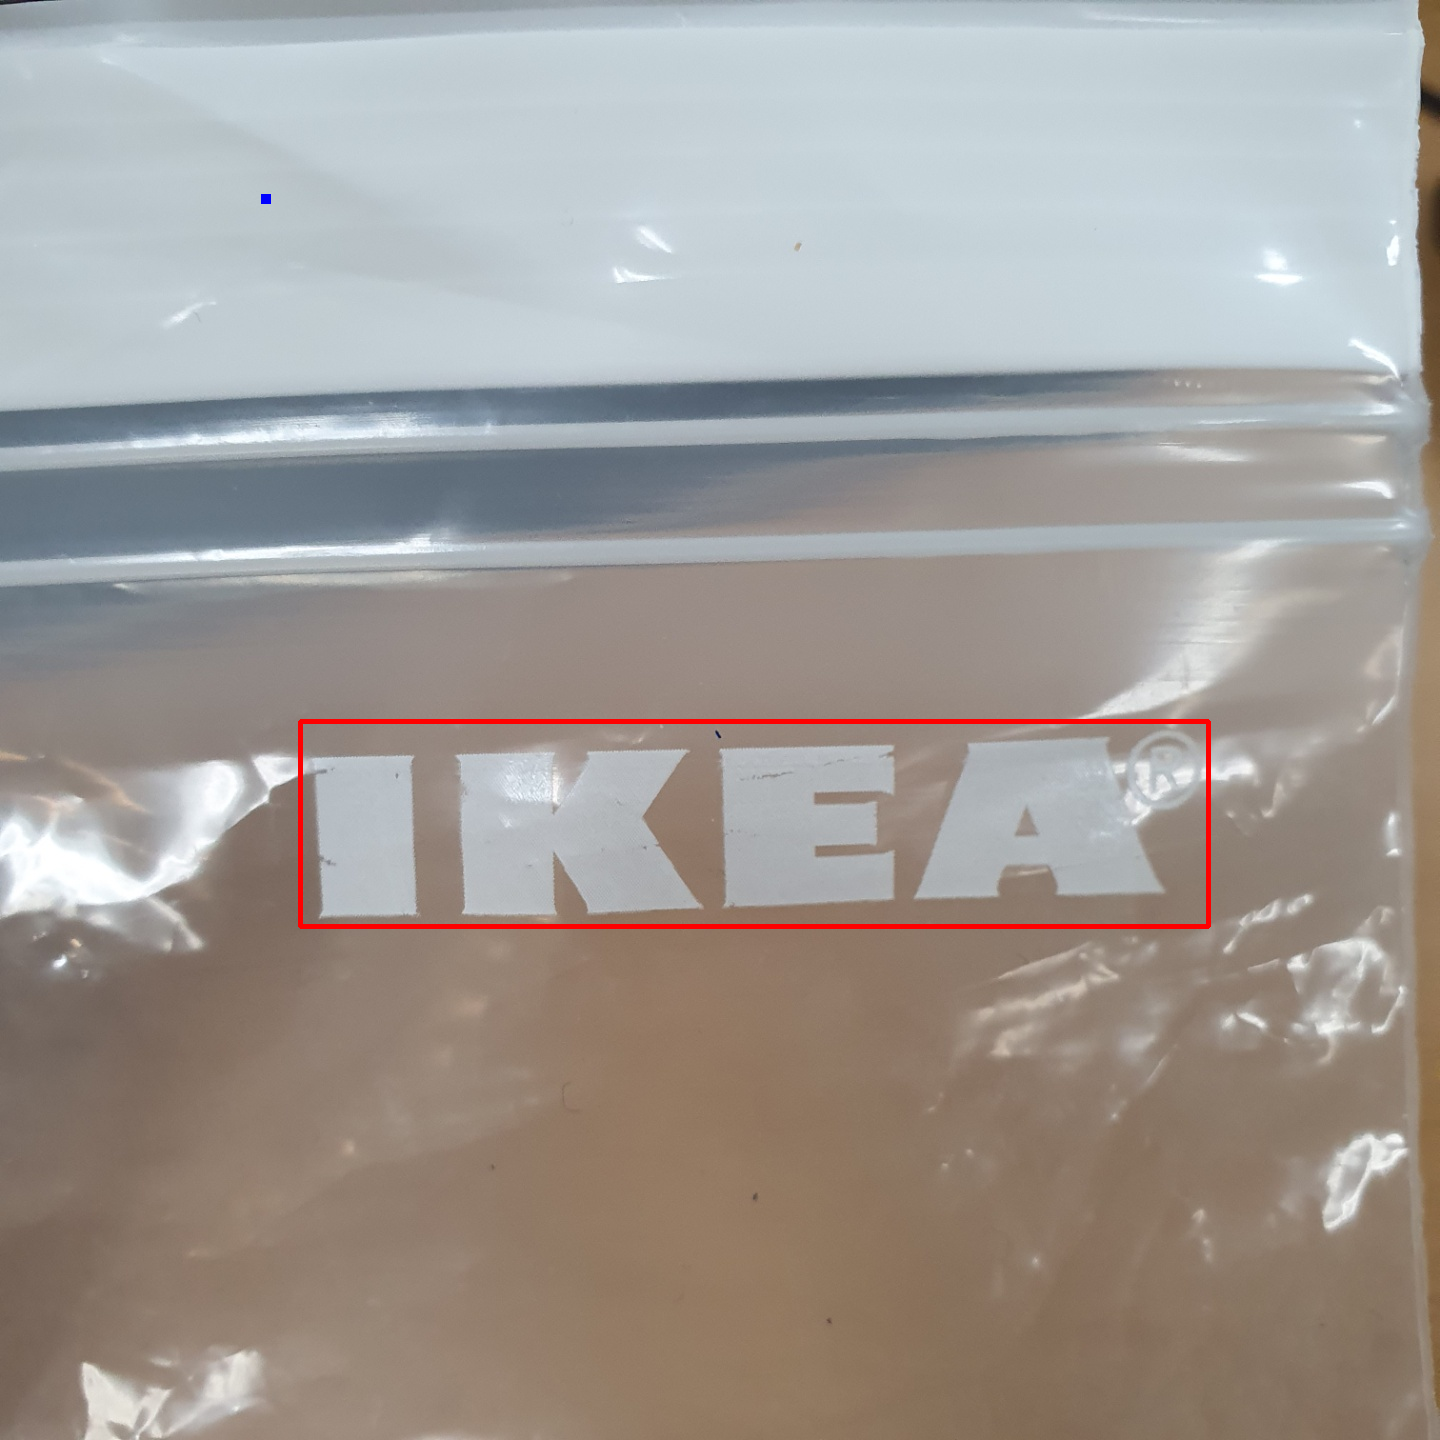

In [65]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image[ img_center[0]-5 : img_center[0]+5, img_center[1]-5: img_center[1]+5] = (0,0, 255)
Image.fromarray(image)

In [66]:
img_center = get_image_center(np.array([[0,0], [image.shape[0]-1, image.shape[1]-1]]))

In [83]:
recognition_list = ['IKEA']

In [84]:
crop_df, image_area = get_weight_df(pts_list, img_center, recognition_list)

In [85]:
crop_df

,center_point,euclidean_list,area_list,recognition_list
0,"(823, 753)",109.416635,161583.0,IKEA


In [68]:
crop_df, cropped_array = fine_filtering(crop_df, cropped_array )

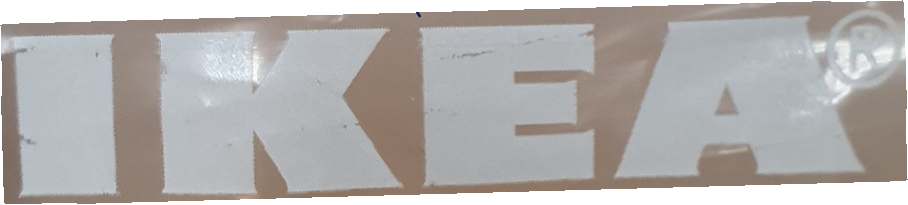

In [69]:
Image.fromarray(cv2.cvtColor(cropped_array[0], cv2.COLOR_BGR2RGB))

In [70]:
total_ratio = get_weight_ratio(crop_df, img_center)

In [71]:
total_ratio

array([0.89239326])

In [72]:
example = ['ikea']

## lexicon search

### 고려사항
- 제조사만 동일하고 제품명이 다를 경우 거르기 -> threshold 기준을 어떻게 설정할 것인가(main 키워드와 운이좋게 매치됬을경우 고려)
- 제조사 영어로 되있을시 

In [73]:
lexicon = pd.read_csv('/home/Data/FoodDetection/Serving/ocr/pipeline/OCR_lexicon_pre.csv' ,error_bad_lines=False)

In [276]:
# lexicon = pd.concat([lexicon, pd.DataFrame([{'FOOD_CD' : 'G012421445', 'preprocess' : 'lotte_행복한주말_사랑나눔'}]) ], axis=0 , ignore_index=True) 

In [596]:
lexicon[lexicon['preprocess'].map(lambda x : True if re.compile('골뱅이').match(x) else False)]

,FOOD_CD,preprocess,ed
655,N243000008,골뱅이통조림,0.0


In [74]:
rest_sum = sum(list(filter(lambda x : x >= total_ratio.mean(), total_ratio)))
threshold =  (rest_sum * 0.7 )/ (len(example)+2)
# if rest_sum < 1 else  rest_sum /  (len(example) * 10**-1)
threshold

0.20822509449472548

In [75]:
start_time = time.time()
ed_list = []

for word in lexicon['preprocess']:
    min_ed = []
    word_split = word.split('_')
    for idx, each in enumerate(example):
        each_ed = []
        for word_ in word_split:
            ed = levenshtein(each.lower(), word_.lower())
            er = 1- (ed/(max(len(word_), len(each))))
            if er <= 0.4:
                er = 0
#             print(f'"{each.lower()}"와 "{word.lower()}"속 단어 "{word_.lower()}" 의  raw ED 값 : {ed},  1- levenshtein 값  : {er}')
#             print(f'"{each.lower()}"와 "{word_.lower()}" 의  raw ED 값 : {ed},  1- levenshtein 값  : {er}')
            each_ed.append(er)
#         min_ed.append(ed_ratio[idx] * max(each_ed))
        min_ed.append(total_ratio[idx] * max(each_ed))
#         min_ed.append(min(each_ed))
    ed_list.append(sum(min_ed)/len(example))

lexicon['ed'] = ed_list

max_data = lexicon[lexicon['ed'] == lexicon['ed'].max()]
if max_data['ed'].max() < threshold:
    print(f'not in lexicon(ED : {max_data["ed"].max()}, threshold : {threshold})')
else:
    most_similar_idx = max_data['preprocess'].apply(lambda x :  abs(len(example) - len(x.split('_')))).sort_values().index[0]
    print(f'Search Result : {lexicon.loc[most_similar_idx]["preprocess"]}, FOOD CD : {lexicon.loc[most_similar_idx]["FOOD_CD"]},  ED : {round(lexicon.loc[most_similar_idx]["ed"],2)}')
    

Search Result : 라essa_EA_진국의마_사리곰랑_s사ml, FOOD CD : N246000140,  ED : 0.45


In [76]:
lexicon = lexicon.sort_values(by = ['ed'],ascending=False)
lexicon.head(30)

,FOOD_CD,preprocess,ed
2494,N245000479,풀무월_Pulmmoneee_즙_48l_MORNINNG_eVERY_UP_POwER_아...,0.446197
2158,N245000713,brand_Asmo_baid_chocolia_Chocolle_CHOCCLATES_m...,0.446197
2254,G001000280,서을우유_얼iii_언lrs_열h_cosses_eiaweerr_laits_벼브_oet...,0.446197
2493,N246000033,Fi_rOYALL_milk_tea_2osssskal,0.446197
2492,G012004131,여퐈지지_BrAND_POTATO_CHIPS_SALT_SEA_tastemnaturllyy,0.446197
2532,N245000774,복합기능_Probioss_sakei_특허유산균_Denmakks_면역_케어_프로젝트_...,0.446197
2488,N246000140,라essa_EA_진국의마_사리곰랑_s사ml,0.446197
2388,N246000458,1F_THL_i_Ocha_Strong_525i_Green_Tea,0.446197
2489,N245000361,pulmuone_생가두_모싸렐라_고로케_불고기_s첨가_4oog_F1SC_5개_전자r...,0.396619
2205,N246000524,팁치즈_버_Deeocheeseurggr_MoMs_TOUCH_chickEn_BURGE...,0.382454


In [600]:
lexicon = lexicon.loc[[655]]

In [285]:
lexicon.head(1)['preprocess'][2462]

'생가득_아늠장r_톤이루키_탕기_NeNI_color_코코s_브라운_길리반죽_연재_팽창계_iollIttt_s색_Nol_촐감발발달_조리예_SMEE_팬조리l_CHT_븐조_ErS_I5oe_EAETT_fds_oS_EcC_ss보관_2oog_cucscaaa'

In [116]:
lexicon.loc[2301]['preprocess']

'unrprestents_후후호초로조_IMPERIAL_BIG_MeAL_마학_hot_pot_SUPER_BEeF_FLAVOR_주a_Beef_austrALA_ifrol_new_zEALAND_and'